# Bonus1: Parallel Algorithms - Federated Averaging

### Name: Connor DePalma


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy as np
import ray # For parrallel processing

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = np.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.00045578  0.04508916  0.05012652  0.25889915  0.02681703 -0.00311605
  -0.02336612 -0.04445211]]
test std = 
[[0.88823886 1.15667411 0.93545276 1.01212056 1.18823563 0.92718506
  0.85664324 0.98752362]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## 1.5 Create Class for Worker Nodes 

In [5]:
@ray.remote # Each worker node will be a Ray Actor
class Worker:
    def __init__(self, x, y):
        
        self.p = x.shape[0] # Num local samples
        self.d = x.shape[1] # num features
        self.w = np.zeros((d,1))
        self.obj = 0
        self.objval = 0
        
        self.current_idx = 0 # Track samples for SGD 
        indices = np.random.permutation(self.p)
        self.x = x[indices,:]
        self.y = y[indices,:]

    def restart(self):
        self.w = np.zeros((self.d,1))
        self.obj = 0
        
        self.current_idx = 0
        indices = np.random.permutation(self.p)
        self.x = self.x[indices,:]
        self.y = self.y[indices,:]
    
    def set_param(self, w):
        self.w = w
    
    def get_param(self):
        return self.w
    
    def get_obj(self):
        return self.obj
        
    def loss(self, x, y):
        yx = numpy.multiply(y,x)
        yxw = numpy.dot(yx, self.w) 
        # calculate loss
        loss = numpy.log(1 + numpy.exp(-yxw)) 
        return np.mean(loss)
      
    def gradient(self, x, y):
        yx = numpy.multiply(y,x) 
        yxw = numpy.dot(yx, self.w) 
        mat = -yx / (1 + numpy.exp(yxw)) 
        g = np.mean(mat, axis=0).reshape(self.d,1)
        return g
    
    def gd_sgd(self, q, l, lam, GD=True):
        x = None
        y = None
        if q > 1 and GD:
            # q obj values should be captured per iteration since 
            # one iteration is one epoch for GD
            self.obj = []
        
        for i in range(q):
            if GD:  
                x = self.x
                y = self.y
                
                if q > 1:
                    # Each iteration here is one epoch
                    # objval should be returned as an array
                    objval = self.loss(x,y)
                    reg = lam/2 * np.dot(self.w.T,self.w).item()
                    obj = objval + reg
                    self.obj.append(obj)
                else:    
                    objval = self.loss(x,y)
                    reg = lam/2 * np.dot(self.w.T,self.w).item()
                    self.obj = objval + reg
                
                g = self.gradient(x,y)
                grad = g + lam*self.w
                self.w = self.w - l * grad
                
            elif not GD:
                x = self.x[self.current_idx,:].reshape(1,self.d)
                y = self.y[self.current_idx,:]
                reg = lam/2 * np.dot(self.w.T,self.w).item()
                self.objval += self.loss(x,y) + reg

                if self.current_idx == self.p - 1:
                    # One epoch complete for SGD
                    self.obj = self.objval/self.p
                    self.current_idx = 0 
                    self.objval = 0
                    # shuffle for next epoch
                    indices = np.random.permutation(self.p)
                    self.x = self.x[indices,:]
                    self.y = self.y[indices,:]
        
                self.current_idx += 1
                
                g = self.gradient(x,y)
                grad = g + lam*self.w
                self.w = self.w - l * grad

## 1.6 Create Class for Server 

In [6]:
class Server:
    def __init__(self, workers, n, d, q, l, lam, epoch):
        self.workers = workers
        self.q = q
        self.l = l
        self.d = d
        self.n = n
        self.lam = lam
        self.epoch = epoch
        self.w = np.zeros((d,1))
        self.obj = np.zeros((self.epoch,1))

    
    def restart(self):
        self.w = np.zeros((d,1))
        self.obj = np.zeros((self.epoch,1))
        for worker in self.workers:
            worker.restart.remote()
    
    def broadcast(self):
        for worker in self.workers:
            worker.set_param.remote(self.w)
            
    def get_param(self):
        return self.w
    
    def get_obj(self):
        return self.obj

    def aggregate_obj(self):
        nz = np.count_nonzero(self.obj)
        for worker in self.workers:
            obj = ray.get(worker.get_obj.remote())
            obj = [obj] if np.isscalar(obj) else np.array(obj).reshape(len(obj),1)
            self.obj[nz:nz+len(obj),:] =  self.obj[nz:nz+len([obj]),:] + obj
        self.obj[nz:nz+len(obj),:] =  self.obj[nz:nz+len(obj),:]/len(self.workers)
            
    def aggregate(self):
        self.w = np.zeros((self.d,1))
        for worker in self.workers:
            w = ray.get(worker.get_param.remote())
            self.w += w
        self.w /= len(self.workers)
#         self.l *= 0.9
    
    def gd_sgd(self, GD=True):
        self.obj = np.zeros((self.epoch,1))
        
        p = self.n/len(self.workers)
        b = p if GD else 1
        comm_per_epoch = p/(self.q*b)
        print(f"Communications Per Epoch: {comm_per_epoch}")
        
        comm = comm_per_epoch*self.epoch # should set epoch as multiple of 8 to have an integer number of communications when q=8 for GD
        print(f"Total Communications needed: {comm}")
        for i in range(int(np.ceil(comm))):
            self.broadcast()
            for worker in self.workers:
                worker.gd_sgd.remote(self.q, self.l, self.lam, GD)
            self.aggregate()   
            if GD:
                self.aggregate_obj() # get obj values for each communication with GD
            elif not GD:
                if (i+1)%(int(comm_per_epoch)) == 0:
                    self.aggregate_obj() # Only get obj values once a full epoch has occured for SGD
        

## 1.7 Create Function to Run Simulation 

In [7]:
def Fed_Avg_Sim(x,y,m,l,lam,q,GD,epochs):
    
    ray.shutdown()
    ray.init(num_cpus=4, ignore_reinit_error=True)
    
    workers = []
    n,d = x_train.shape
    sections = n//m
    
    for i in range(m):
        worker = Worker.remote(x_train[i*sections:(i+1)*sections,:],y_train[i*sections:(i+1)*sections,:])
        workers.append(worker)
        
    S = Server(workers, n, d, q, l, lam, epochs)
    S.gd_sgd(GD)
    w = S.get_param()
    obj = S.get_obj()
    
    return w, obj 

## 1.8 Run Specified Simulations 

In [8]:
m = 4
l = 1E-1
lam = 1E-6
epochs = 128

print(f"Running Sim for SGD w/ q = 1")
w_sgd_1, obj_sgd_1 = Fed_Avg_Sim(x_train,y_train,m,l,lam,1,False,epochs)
print()
print(f"Running Sim for SGD w/ q = 8")
w_sgd_8, obj_sgd_8 = Fed_Avg_Sim(x_train,y_train,m,l,lam,8,False,epochs)
print()
print(f"Running Sim for GD w/ q = 1")
w_gd_1, obj_gd_1 = Fed_Avg_Sim(x_train,y_train,m,l,lam,1,True,epochs)
print()
print(f"Running Sim for GD w/ q = 8")
w_gd_8, obj_gd_8 = Fed_Avg_Sim(x_train,y_train,m,l,lam,8,True,epochs)

Running Sim for SGD w/ q = 1


2021-04-11 22:56:04,359	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


Communications Per Epoch: 160.0
Total Communications needed: 20480.0

Running Sim for SGD w/ q = 8


2021-04-11 22:58:26,672	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


Communications Per Epoch: 20.0
Total Communications needed: 2560.0

Running Sim for GD w/ q = 1


2021-04-11 22:58:53,287	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


Communications Per Epoch: 1.0
Total Communications needed: 128.0

Running Sim for GD w/ q = 8


2021-04-11 22:58:59,060	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


Communications Per Epoch: 0.125
Total Communications needed: 16.0


## 1.9 Look at Results

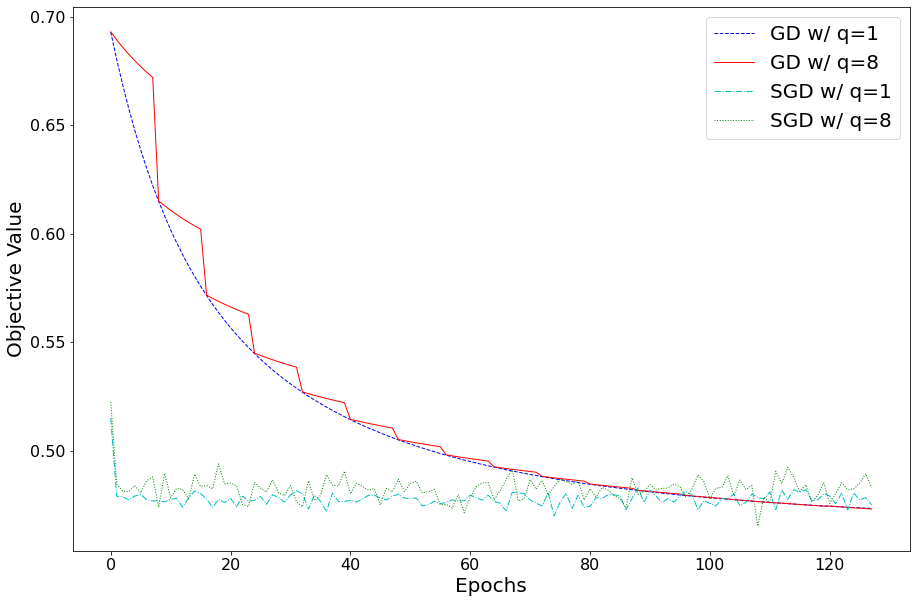

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 10))

epochs_range = range(epochs)

line0, = plt.plot(epochs_range, obj_gd_1, '--b', linewidth=1)
line1, = plt.plot(epochs_range, obj_gd_8, '-r', linewidth=1)
line2, = plt.plot(epochs_range, obj_sgd_1, '-.c', linewidth=1)
line3, = plt.plot(epochs_range, obj_sgd_8, ':g', linewidth=1)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1, line2, line3], ['GD w/ q=1', 'GD w/ q=8', 'SGD w/ q=1', 'SGD w/ q=8'], fontsize=20)
plt.show()

In [10]:
# look at final Objective Function Values

print(f"last Objective value for GD w/ q=1 is {obj_gd_1[-1]}")
print(f"last Objective value for GD w/ q=8 is {obj_gd_8[-1]}")
print(f"last Objective value for SGD w/ q=1 is {obj_sgd_1[-1]}")
print(f"last Objective value for SGD w/ q=8 is {obj_sgd_8[-1]}")

last Objective value for GD w/ q=1 is [0.47341661]
last Objective value for GD w/ q=8 is [0.4731754]
last Objective value for SGD w/ q=1 is [0.47513435]
last Objective value for SGD w/ q=8 is [0.4830383]


In [11]:
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [12]:
# evaluate test errors
f_test_gd1 = predict(w_gd_1, x_test)
f_test_gd8 = predict(w_gd_8, x_test)
f_test_sgd1 = predict(w_sgd_1, x_test)
f_test_sgd8 = predict(w_sgd_8, x_test)

diff_gd1 = numpy.abs(f_test_gd1 - y_test) / 2
diff_gd8 = numpy.abs(f_test_gd8 - y_test) / 2
diff_sgd1 = numpy.abs(f_test_sgd1 - y_test) / 2
diff_sgd8 = numpy.abs(f_test_sgd8 - y_test) / 2

error_test_gd1 = numpy.mean(diff_gd1)
error_test_gd8 = numpy.mean(diff_gd8)
error_test_sgd1 = numpy.mean(diff_sgd1)
error_test_sgd8 = numpy.mean(diff_sgd8)

print('testing classification error for GD w/ q=1 is ' + str(error_test_gd1))
print('testing classification error for GD w/ q=8 is ' + str(error_test_gd8))
print('testing classification error for SGD w/ q=1 is ' + str(error_test_sgd1))
print('testing classification error for SGD w/ q=8 is ' + str(error_test_sgd8))

testing classification error for GD w/ q=1 is 0.234375
testing classification error for GD w/ q=8 is 0.234375
testing classification error for SGD w/ q=1 is 0.2265625
testing classification error for SGD w/ q=8 is 0.2421875
